# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# FashionMNIST 분류 모델 만들기
* 흑/백(1) 이미지 데이터 분류
* 28x28 pixel

## 데이터 로드

In [5]:
# 데이터 전처리

MNIST_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [6]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=MNIST_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=MNIST_transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



input-data size 확인

In [7]:
# batch-size=128
train_loader128 =  DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader128 =  DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# batch-size=64
train_loader64 =  DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader64 =  DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [8]:
# 128 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images128, labels128 = next(iter(train_loader128))
images128.shape, labels128.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
# 64 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images64, labels64 = next(iter(train_loader64))
images64.shape, labels64.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

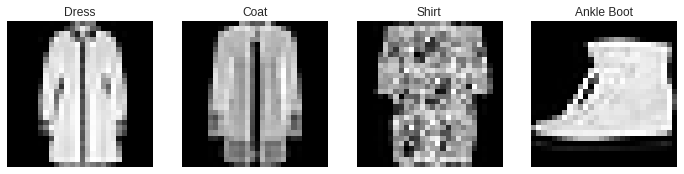

In [11]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images128[i].squeeze()
    label_idx = labels128[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## 모델 1 생성
* 10개의 convolution-layer(Conv2d)와 2개의 fully-connected(fc)로 이루어진 모델
* Total params: 28,784

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* convolution-layer 3
* convolution-layer 4
* convolution-layer 5
* convolution-layer 6
* convolution-layer 7
* convolution-layer 8
* convolution-layer 9
* maxpooling-layer
* convolution-layer 10
* flatten
* fc1
* fc2

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc2에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.
1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 16, 16, 16])
> * torch.Size([128 or 64, 19, 15, 15])
> * torch.Size([128 or 64, 29, 13, 13])
> * torch.Size([128 or 64, 29, 14, 14])
> * torch.Size([128 or 64, 6, 12, 12])
> * torch.Size([128 or 64, 2, 12, 12])
> * torch.Size([128 or 64, 10, 7, 7])
> * torch.Size([128 or 64, 10, 3, 3])
> * torch.Size([128 or 64, 20, 3, 3])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10]) 

In [12]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        # in-channels = 1 <- 흑/백
        # out-channels = 5
        # kernel_size / filter-size = 2x2 -> f=3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 28x28 -> n=28
        # (n-f+2p)/s + 1 = new n
        # (28-3+2x2)/1 + 1 = 30
    
        # self.pool1 = nn.MaxPool2d(kernel_size=2) #maxpool : n=30 -> 15

        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        # in-channels = 5 <- 이전것의 out-channels
        # out-channels = 7
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 1
        # (n-f+2p)/s + 1 = new n    
        # (15-3+2x1)/1 + 1 = 15

        self.conv3 = nn.Conv2d(7, 16, 2,padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19,29, 3)
        self.conv6 = nn.Conv2d(29, 29,2, padding=1)
        self.conv7 = nn.Conv2d(29, 6, 3)
        self.conv8 = nn.Conv2d(6, 2, 1)
        self.conv9 = nn.Conv2d(2, 10, 2, stride=2, padding=1)
        self.conv10 = nn.Conv2d(10, 20, 1, stride=1)

        self.fc1 = nn.Linear(20*3*3, 86)
        self.fc2 = nn.Linear(86,10)


    def forward(self, x):

      x = F.relu(self.conv1(x))

      x = F.max_pool2d(x, kernel_size=2, stride=2)

      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.relu(self.conv5(x))
      x = F.relu(self.conv6(x))
      x = F.relu(self.conv7(x))
      x = F.relu(self.conv8(x))
      x = F.relu(self.conv9(x))
      x = F.relu(self.conv10(x))

      x = F.max_pool2d(x, kernel_size=2, stride=2)

      x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      
      return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [13]:
# 모델객체 생성
DeepConv_net128 = CNN_Model1().to(device)
DeepConv_net64 = CNN_Model1().to(device)

print(DeepConv_net128)

CNN_Model1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(29, 29, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(29, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(6, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(2, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv10): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=180, out_features=86, bias=True)
  (fc2): Linear(in_features=86, out_features=10, bias=True)
)


In [14]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [15]:
output = DeepConv_net128.forward(input)
output.size()

torch.Size([128, 10])

In [16]:
summary(DeepConv_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Conv2d-6          [128, 29, 14, 14]           3,393
            Conv2d-7           [128, 6, 12, 12]           1,572
            Conv2d-8           [128, 2, 12, 12]              14
            Conv2d-9            [128, 10, 7, 7]              90
           Conv2d-10            [128, 20, 7, 7]             220
           Linear-11                  [128, 86]          15,566
           Linear-12                  [128, 10]             870
Total params: 28,784
Trainable params: 28,784
Non-trainable params: 0
---------------------------------

In [17]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [18]:
output = DeepConv_net64.forward(input)
output.size()

torch.Size([64, 10])

In [19]:
summary(DeepConv_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Conv2d-3           [64, 16, 16, 16]             464
            Conv2d-4           [64, 19, 15, 15]           1,235
            Conv2d-5           [64, 29, 13, 13]           4,988
            Conv2d-6           [64, 29, 14, 14]           3,393
            Conv2d-7            [64, 6, 12, 12]           1,572
            Conv2d-8            [64, 2, 12, 12]              14
            Conv2d-9             [64, 10, 7, 7]              90
           Conv2d-10             [64, 20, 7, 7]             220
           Linear-11                   [64, 86]          15,566
           Linear-12                   [64, 10]             870
Total params: 28,784
Trainable params: 28,784
Non-trainable params: 0
---------------------------------

## 모델 2 생성
* 2개의 convolution-layer(Conv2d)와 5개의 fully-connected(fc)로 이루어진 모델
* Total params: 9,516,488

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* flatten
* fc1
* fc2
* fc3
* fc4
* fc5

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc5에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.

1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 1575])
> * torch.Size([128 or 64, 3000])
> * torch.Size([128 or 64, 1500])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10])

In [21]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        
        self.fc1 = nn.Linear(7*15*15, 3000)
        self.fc2 = nn.Linear(3000,1500)
        self.fc3 = nn.Linear(1500,180)
        self.fc4 = nn.Linear(180,86)
        self.fc5 = nn.Linear(86,10)

    def forward(self, x):
      
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, kernel_size=2, stride=2)
      x = F.relu(self.conv2(x))
     
      x = x.view(-1, self.num_flat_features(x)) 

      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.fc5(x)

      return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [22]:
# 모델객체 생성
DeepFC_net128 = CNN_Model2().to(device)
DeepFC_net64 = CNN_Model2().to(device)

print(DeepFC_net128)

CNN_Model2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1575, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [23]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [24]:
output = DeepFC_net128.forward(input)
output.size()

torch.Size([128, 10])

In [25]:
summary(DeepFC_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Linear-3                [128, 3000]       4,728,000
            Linear-4                [128, 1500]       4,501,500
            Linear-5                 [128, 180]         270,180
            Linear-6                  [128, 86]          15,566
            Linear-7                  [128, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 10.60
Params size (MB): 36.30
Estimated Total Size (MB): 47.28
----------------------------------------------------------------


In [26]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [27]:
output = DeepFC_net64.forward(input)
output.size()

torch.Size([64, 10])

In [28]:
summary(DeepFC_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Linear-3                 [64, 3000]       4,728,000
            Linear-4                 [64, 1500]       4,501,500
            Linear-5                  [64, 180]         270,180
            Linear-6                   [64, 86]          15,566
            Linear-7                   [64, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.30
Params size (MB): 36.30
Estimated Total Size (MB): 41.79
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [29]:
criterion = nn.CrossEntropyLoss()

optimizerDC_128 = optim.SGD(DeepConv_net128.parameters(), lr=0.001, momentum=0.9)
optimizerDC_64 = optim.SGD(DeepConv_net64.parameters(), lr=0.001, momentum=0.9)
optimizerFC_128 = optim.SGD(DeepFC_net128.parameters(), lr=0.001, momentum=0.9)
optimizerFC_64 = optim.SGD(DeepFC_net64.parameters(), lr=0.001, momentum=0.9)

In [30]:
list(DeepConv_net128.parameters())

[Parameter containing:
 tensor([[[[ 0.2059, -0.0621, -0.2409],
           [ 0.2960, -0.1839, -0.2127],
           [-0.3013,  0.1040,  0.2681]]],
 
 
         [[[ 0.0496,  0.1972, -0.2635],
           [-0.1984, -0.1633,  0.3106],
           [-0.0871,  0.1895, -0.2637]]],
 
 
         [[[ 0.1571,  0.1551,  0.0781],
           [-0.1451, -0.2408,  0.2071],
           [ 0.1071, -0.0687, -0.0144]]],
 
 
         [[[-0.0073,  0.1234, -0.1458],
           [ 0.3053, -0.0984, -0.3185],
           [ 0.0512, -0.0928, -0.1516]]],
 
 
         [[[-0.0583,  0.1043, -0.0573],
           [-0.0045, -0.2389, -0.0740],
           [-0.0057,  0.0235,  0.1935]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.1865, -0.2053, -0.0928, -0.0157,  0.2918], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.0115, -0.1471, -0.0067],
           [ 0.0147,  0.1008, -0.0224],
           [-0.1254, -0.1435, -0.1044]],
 
          [[ 0.0020, -0.0069,  0.0897],
  

## 모델 학습

### 1. DeepConv_net128
* 10개의 Convolution-layer & 2개의 fc-layer
* 128 batch-size

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11519551599025726
Epoch: 1, Iter: 200, Loss: 0.11518183267116547
Epoch: 1, Iter: 300, Loss: 0.11516895914077759
Epoch: 1, Iter: 400, Loss: 0.11513185811042785
Epoch: 2, Iter: 100, Loss: 0.11514386808872223
Epoch: 2, Iter: 200, Loss: 0.11513223600387573
Epoch: 2, Iter: 300, Loss: 0.11513690841197967
Epoch: 2, Iter: 400, Loss: 0.11512941801548005
Epoch: 3, Iter: 100, Loss: 0.11513103032112122
Epoch: 3, Iter: 200, Loss: 0.11513402438163757
Epoch: 3, Iter: 300, Loss: 0.1151279695034027
Epoch: 3, Iter: 400, Loss: 0.11513805556297302
Epoch: 4, Iter: 100, Loss: 0.11512885868549347
Epoch: 4, Iter: 200, Loss: 0.11513289904594422
Epoch: 4, Iter: 300, Loss: 0.11513558006286621
Epoch: 4, Iter: 400, Loss: 0.11513321149349212
Epoch: 5, Iter: 100, Loss: 0.11513206028938293
Epoch: 5, Iter: 200, Loss: 0.11513136851787567
Epoch: 5, Iter: 300, Loss: 0.11513586664199829
Epoch: 5, Iter: 400, Loss: 0.11513313257694244
Epoch: 6, Iter: 100, Loss: 0.11512799155712128
Epoch: 6, Iter

In [ ]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11513074862957001
Epoch: 1, Iter: 200, Loss: 0.11513446009159088
Epoch: 1, Iter: 300, Loss: 0.11513272130489349
Epoch: 1, Iter: 400, Loss: 0.11513210201263428
Epoch: 2, Iter: 100, Loss: 0.11513077616691589
Epoch: 2, Iter: 200, Loss: 0.1151345077753067
Epoch: 2, Iter: 300, Loss: 0.11513259983062744
Epoch: 2, Iter: 400, Loss: 0.11513358938694
Epoch: 3, Iter: 100, Loss: 0.11513058471679688
Epoch: 3, Iter: 200, Loss: 0.1151332448720932
Epoch: 3, Iter: 300, Loss: 0.11513393425941468
Epoch: 3, Iter: 400, Loss: 0.11513353252410889
Epoch: 4, Iter: 100, Loss: 0.11513270676136017
Epoch: 4, Iter: 200, Loss: 0.11513199532032013
Epoch: 4, Iter: 300, Loss: 0.11513204061985016
Epoch: 4, Iter: 400, Loss: 0.11513066554069519
Epoch: 5, Iter: 100, Loss: 0.11512999844551086
Epoch: 5, Iter: 200, Loss: 0.11513445377349854
Epoch: 5, Iter: 300, Loss: 0.11513398611545562
Epoch: 5, Iter: 400, Loss: 0.11513250803947449


### 2. DeepConv_net64
* 10개의 Convolution-layer & 2개의 fc-layer
* 64 batch-size

In [31]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11520582962036133
Epoch: 1, Iter: 200, Loss: 0.11515708065032959
Epoch: 1, Iter: 300, Loss: 0.11518690538406372
Epoch: 1, Iter: 400, Loss: 0.11519351625442505
Epoch: 1, Iter: 500, Loss: 0.11516457748413086
Epoch: 1, Iter: 600, Loss: 0.11513939571380616
Epoch: 1, Iter: 700, Loss: 0.11513098406791687
Epoch: 1, Iter: 800, Loss: 0.11514121484756469
Epoch: 1, Iter: 900, Loss: 0.11515822052955628
Epoch: 2, Iter: 100, Loss: 0.11512601101398467
Epoch: 2, Iter: 200, Loss: 0.11513238191604615
Epoch: 2, Iter: 300, Loss: 0.11513799011707306
Epoch: 2, Iter: 400, Loss: 0.11513020086288452
Epoch: 2, Iter: 500, Loss: 0.11514096748828888
Epoch: 2, Iter: 600, Loss: 0.11513701868057251
Epoch: 2, Iter: 700, Loss: 0.11513840866088867
Epoch: 2, Iter: 800, Loss: 0.11513441705703735
Epoch: 2, Iter: 900, Loss: 0.11513135957717896
Epoch: 3, Iter: 100, Loss: 0.11513435328006745
Epoch: 3, Iter: 200, Loss: 0.11513389277458191
Epoch: 3, Iter: 300, Loss: 0.11513591802120209
Epoch: 3, Ite

### 3. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 128 batch-size

In [32]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518005192279816
Epoch: 1, Iter: 200, Loss: 0.11519184458255768
Epoch: 1, Iter: 300, Loss: 0.11514383614063263
Epoch: 1, Iter: 400, Loss: 0.115081702709198
Epoch: 2, Iter: 100, Loss: 0.11501030778884888
Epoch: 2, Iter: 200, Loss: 0.11498661851882934
Epoch: 2, Iter: 300, Loss: 0.11493247652053833
Epoch: 2, Iter: 400, Loss: 0.11487038516998291
Epoch: 3, Iter: 100, Loss: 0.11468621325492859
Epoch: 3, Iter: 200, Loss: 0.11452919900417328
Epoch: 3, Iter: 300, Loss: 0.1142582688331604
Epoch: 3, Iter: 400, Loss: 0.11384443795681
Epoch: 4, Iter: 100, Loss: 0.11193005621433258
Epoch: 4, Iter: 200, Loss: 0.10825931882858277
Epoch: 4, Iter: 300, Loss: 0.09274175983667374
Epoch: 4, Iter: 400, Loss: 0.06271556425094604
Epoch: 5, Iter: 100, Loss: 0.04736812299489975
Epoch: 5, Iter: 200, Loss: 0.04374554780125618
Epoch: 5, Iter: 300, Loss: 0.04030944472551346
Epoch: 5, Iter: 400, Loss: 0.037383429914712905
Epoch: 6, Iter: 100, Loss: 0.034611463248729706
Epoch: 6, Iter: 2

### 4. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 64 batch-size

In [33]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518280160427094
Epoch: 1, Iter: 200, Loss: 0.11510010290145874
Epoch: 1, Iter: 300, Loss: 0.11502699208259583
Epoch: 1, Iter: 400, Loss: 0.1149621354341507
Epoch: 1, Iter: 500, Loss: 0.11485442578792572
Epoch: 1, Iter: 600, Loss: 0.11463445818424225
Epoch: 1, Iter: 700, Loss: 0.11439471518993377
Epoch: 1, Iter: 800, Loss: 0.11385406291484833
Epoch: 1, Iter: 900, Loss: 0.11279462134838104
Epoch: 2, Iter: 100, Loss: 0.10428898292779923
Epoch: 2, Iter: 200, Loss: 0.07350708532333373
Epoch: 2, Iter: 300, Loss: 0.050382995069026944
Epoch: 2, Iter: 400, Loss: 0.04326126450300217
Epoch: 2, Iter: 500, Loss: 0.03923976281285286
Epoch: 2, Iter: 600, Loss: 0.036183226749300954
Epoch: 2, Iter: 700, Loss: 0.03386902944743633
Epoch: 2, Iter: 800, Loss: 0.03241530030965805
Epoch: 2, Iter: 900, Loss: 0.032333432644605635
Epoch: 3, Iter: 100, Loss: 0.03032189601659775
Epoch: 3, Iter: 200, Loss: 0.029711391016840935
Epoch: 3, Iter: 300, Loss: 0.029390687838196754
Epoch: 3,

## 모델 테스트

In [34]:
# 전체 test 데이터에 대해서 성능 확인

correct_list = [0]*4
total_list = [0]*4
a = -1

model_list = {'DeepConv' : [DeepConv_net128, DeepConv_net64],
              'DeepFC' : [DeepFC_net128, DeepFC_net64]}
data_list = [test_loader128, test_loader64]

with torch.no_grad(): # grad가 필요없다.

    for key in model_list:
        for idx in range(len(model_list[key])):
            a += 1
            model = model_list[key][idx]
            data_loader = data_list[idx]
            for data in data_loader:
                images, labels = data[0].to(device), data[1].to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_list[a] += labels.size(0)
                correct_list[a] += (predicted == labels).sum().item()
            
correct_rate = np.array(correct_list) / np.array(total_list)
model_name = ['DeepConv_net128', 'DeepConv_net64', 'DeepFC_net128', 'DeepFC_net64']

for i in range(len(correct_rate)):
    print('{0} : {1}'.format(model_name[i], correct_rate[i]))

DeepConv_net128 : 0.1
DeepConv_net64 : 0.1
DeepFC_net128 : 0.85
DeepFC_net64 : 0.8618


# FashionMNIST 분류 모델 중 성능이 낮은 모델 이유 확인

## Convolution-layer를 하나씩 추가하면서, 성능변화를 관찰

### 3개의 convolution-layer 사용시

In [35]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)

        self.fc1 = nn.Linear(16* 16 * 16, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [36]:
# 모델객체 생성
new_model = CNN_Model3().to(device)

print(new_model)

CNN_Model3(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [37]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Linear-4                [128, 3000]      12,291,000
            Linear-5                [128, 1500]       4,501,500
            Linear-6                 [128, 180]         270,180
            Linear-7                  [128, 86]          15,566
            Linear-8                  [128, 10]             870
Total params: 17,079,952
Trainable params: 17,079,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 14.60
Params size (MB): 65.15
Estimated Total Size (MB): 80.13
----------------------------------------------------------------


In [38]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [39]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11524898982048035
Epoch: 1, Iter: 200, Loss: 0.11521780502796174
Epoch: 1, Iter: 300, Loss: 0.11515916621685028
Epoch: 1, Iter: 400, Loss: 0.11516554570198059
Epoch: 2, Iter: 100, Loss: 0.11508579969406128
Epoch: 2, Iter: 200, Loss: 0.11503022491931915
Epoch: 2, Iter: 300, Loss: 0.11499036288261413
Epoch: 2, Iter: 400, Loss: 0.11490582025051117
Epoch: 3, Iter: 100, Loss: 0.11473555016517639
Epoch: 3, Iter: 200, Loss: 0.11455208992958069
Epoch: 3, Iter: 300, Loss: 0.11424302482604981
Epoch: 3, Iter: 400, Loss: 0.11342054200172424
Epoch: 4, Iter: 100, Loss: 0.1003921110033989
Epoch: 4, Iter: 200, Loss: 0.07128662538528442
Epoch: 4, Iter: 300, Loss: 0.047115300953388214
Epoch: 4, Iter: 400, Loss: 0.04059761384129524
Epoch: 5, Iter: 100, Loss: 0.03483499716222286
Epoch: 5, Iter: 200, Loss: 0.03334216153621673
Epoch: 5, Iter: 300, Loss: 0.03190553872287273
Epoch: 5, Iter: 400, Loss: 0.03146067963540554
Epoch: 6, Iter: 100, Loss: 0.030212381944060326
Epoch: 6, It

In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

81.42


### 4개의 convolution-layer 사용시

In [53]:
class CNN_Model4(nn.Module):
    def __init__(self):
        super(CNN_Model4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)

        self.fc1 = nn.Linear(15* 15 * 19, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [54]:
# 모델객체 생성
new_model = CNN_Model4().to(device)

print(new_model)

CNN_Model4(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=4275, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [55]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Linear-5                [128, 3000]      12,828,000
            Linear-6                [128, 1500]       4,501,500
            Linear-7                 [128, 180]         270,180
            Linear-8                  [128, 86]          15,566
            Linear-9                  [128, 10]             870
Total params: 17,618,187
Trainable params: 17,618,187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.77
Params size (MB): 67.21
Estimated Total Size (MB): 86.36
----------------------------------

In [56]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [57]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11517180609703064
Epoch: 1, Iter: 200, Loss: 0.11521607398986816
Epoch: 1, Iter: 300, Loss: 0.11516846406459809
Epoch: 1, Iter: 400, Loss: 0.11512344086170197
Epoch: 2, Iter: 100, Loss: 0.11513619339466095
Epoch: 2, Iter: 200, Loss: 0.115129065990448
Epoch: 2, Iter: 300, Loss: 0.1151358083486557
Epoch: 2, Iter: 400, Loss: 0.11512762999534606
Epoch: 3, Iter: 100, Loss: 0.11511150455474853
Epoch: 3, Iter: 200, Loss: 0.11512007594108581
Epoch: 3, Iter: 300, Loss: 0.11511625576019287
Epoch: 3, Iter: 400, Loss: 0.11512160396575928
Epoch: 4, Iter: 100, Loss: 0.11511062264442444
Epoch: 4, Iter: 200, Loss: 0.11510887444019317
Epoch: 4, Iter: 300, Loss: 0.11511075067520142
Epoch: 4, Iter: 400, Loss: 0.11510381722450257
Epoch: 5, Iter: 100, Loss: 0.11509954595565795
Epoch: 5, Iter: 200, Loss: 0.1151021203994751
Epoch: 5, Iter: 300, Loss: 0.11509722995758057
Epoch: 5, Iter: 400, Loss: 0.115092515707016
Epoch: 6, Iter: 100, Loss: 0.1150888068675995
Epoch: 6, Iter: 200,

In [58]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

33.37


### 5개의 convolution-layer 사용시

In [47]:
class CNN_Model5(nn.Module):
    def __init__(self):
        super(CNN_Model5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)      
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19, 29, 3)

        self.fc1 = nn.Linear(29 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [48]:
# 모델객체 생성
new_model = CNN_Model5().to(device)

print(new_model)

CNN_Model5(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4901, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=10, bias=True)
)


In [49]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Linear-6                 [128, 100]         490,200
            Linear-7                  [128, 50]           5,050
            Linear-8                  [128, 25]           1,275
            Linear-9                  [128, 10]             260
Total params: 503,844
Trainable params: 503,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 19.07
Params size (MB): 1.92
Estimated Total Size (MB): 21.38
-----------------------------------------

In [50]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [51]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11540267276763916
Epoch: 1, Iter: 200, Loss: 0.11540339875221252
Epoch: 1, Iter: 300, Loss: 0.11525209379196168
Epoch: 1, Iter: 400, Loss: 0.11532430696487427
Epoch: 2, Iter: 100, Loss: 0.11522586917877198
Epoch: 2, Iter: 200, Loss: 0.11520208370685578
Epoch: 2, Iter: 300, Loss: 0.1151688916683197
Epoch: 2, Iter: 400, Loss: 0.11516394746303558
Epoch: 3, Iter: 100, Loss: 0.11516771423816681
Epoch: 3, Iter: 200, Loss: 0.11511723983287811
Epoch: 3, Iter: 300, Loss: 0.11515006244182587
Epoch: 3, Iter: 400, Loss: 0.11514078831672668
Epoch: 4, Iter: 100, Loss: 0.115137176156044
Epoch: 4, Iter: 200, Loss: 0.1151236058473587
Epoch: 4, Iter: 300, Loss: 0.1151308525800705
Epoch: 4, Iter: 400, Loss: 0.11512261044979095
Epoch: 5, Iter: 100, Loss: 0.1151228438615799
Epoch: 5, Iter: 200, Loss: 0.11512142777442932
Epoch: 5, Iter: 300, Loss: 0.1151164220571518
Epoch: 5, Iter: 400, Loss: 0.11512335944175721
Epoch: 6, Iter: 100, Loss: 0.11511355900764465
Epoch: 6, Iter: 200,

In [52]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

24.93
